# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 2:  $k$-NN and Linear Regression 

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

**Partner's: Sunil Kumar Shambulingaiah and Steven Devisch** 

<hr style="height:2pt">

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

# <div class="theme"> Predicting Taxi Pickups in NYC </div>

In this homework, we will explore $k$-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York City at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

## <div class="exercise"> <b> Question 1  [13 pts]</b> </div>

**1.1 [2 pts]**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2 [3 pts]**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.

**1.3 [4 pts]**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4 [4 pts]**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.


### Answers

**1.1 [2 pts]. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 109 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.**

In [3]:
# read the file
data = pd.read_csv("./data/nyc_taxi.csv")

In [4]:
# split the data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)


In [5]:
# take a quick look at the data
print("length train data:", len(train_data))
print("length test data:", len(test_data))
print(test_data.head())

length train data: 1000
length test data: 250
      TimeMin  PickupCount  Day
1052      486           34  Mon
916       420           13  Sat
284      1138           75  Sat
176       645           22  Thu
219      1140           62  Fri


**1.2 [3 pts]. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is related to the time of the day.  Always be sure to title your plot.**

In [6]:
# exploratory analysis
print("The highest number of minutes in the data is:", max(data['TimeMin']), ". A day can have", 60*24, "minutes")

The highest number of minutes in the data is: 1438 . A day can have 1440 minutes


In [7]:
# look at some basic statistics 
data.describe()

,TimeMin,PickupCount
count,1250.00000,1250.000000
mean,702.46800,33.230400
std,405.49001,19.136391
min,4.00000,1.000000
25%,361.50000,17.000000
50%,688.50000,33.000000
75%,1046.75000,46.000000
max,1438.00000,116.000000


In [8]:
# list any rows with nulls
data[data.isnull().any(axis=1)]

,TimeMin,PickupCount,Day


**Comment:** everything looks pretty clean and normal. We're not observing any strange values, and there are no nulls. We do expect there will be skewness in the data (there should be more rides at night).

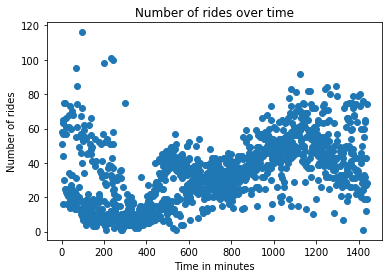

In [9]:
# scatterplot 
plt.scatter(data['TimeMin'],data['PickupCount'])
plt.title("Number of rides over time")
plt.xlabel("Time in minutes")
plt.ylabel("Number of rides")

plt.show()

**Comment:** the relationship seems to be curvilinear. There seem to be some outliers in the early parts of the night as well. I'm assuming this will be correclated to e.g. the day, with more rides happening over the weekend at night.

**1.3 [4 pts]. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**



Taxi usage seems at low at six a clock in the morning, when the day starts for most people, and most partyers have settled for the night. As the day moves forward, the number of rides goes up. During the early hours in the morning, there seems to some outliers. I'm assuming this will be correclated to e.g. the day of the week, with more night rides happening over the weekend. Overall the relationship seems to be curvilinear

**1.4 [4 pts]. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly speculate why this is the case; use the data to support your claim.**

We hypothesize the "low" is caused by lower morning traffic during the morning peak.
Below plots demonstrate how weekend rides are indeed low during 500-550 minute time window.
During week days the pickup range is between 25 to 50 rides and during weekends its between 0 to 25 showing a clear difference at 500-550 minutes

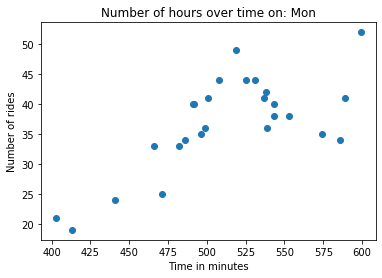

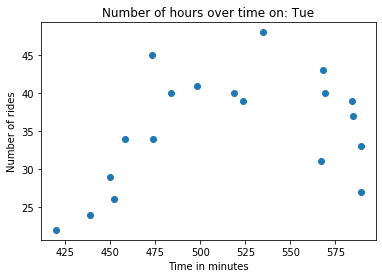

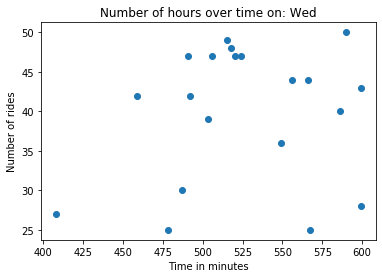

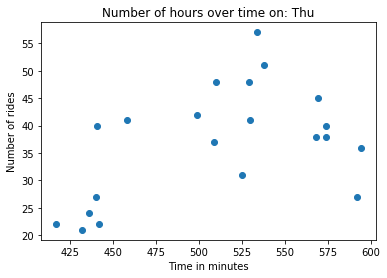

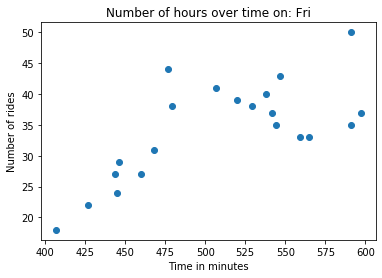

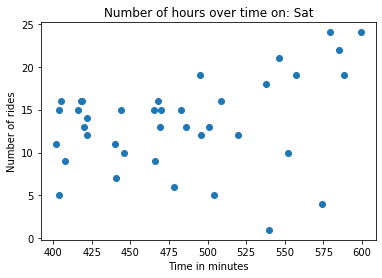

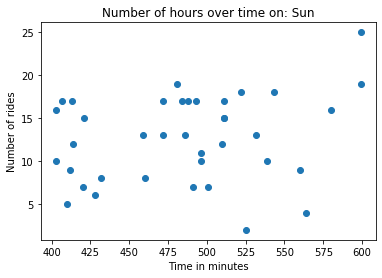

In [10]:
days = ['Mon','Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for day in days:
    one_day_data = data[((data["Day"] == day) & (data["TimeMin"] >= 400) & (data["TimeMin"] <= 600))]
    plt.scatter(one_day_data['TimeMin'],one_day_data['PickupCount'])
    title = "Number of hours over time on: " + day
    plt.title(title)
    plt.xlabel("Time in minutes")
    plt.ylabel("Number of rides")
    plt.show()


## <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen $k$-Nearest Neighbors ($k$-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run $k$-NN Regression. 


**2.1 [4 pts]**. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2 [6 pts]**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3 [3 pts]**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4 [3 pts]**. Plot, in a single figure, the two 'curves' of $R^2$ values from the models on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5 [9 pts]**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

### Answers

**2.1 [4 pts]. Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels` that will be used to predict `PickupCount` based on `TimeMin`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`).**


In [11]:
# Make our lives easy by storing the different regressors in a dictionary
KNNModels = {}

# Make our lives easier by entering the k values from a list
k_list = [1,10,75,250,500,750,1000]

# shape the data as expected by the algorithm
X_train = train_data['TimeMin']
X_train_np = X_train.to_numpy().reshape(-1,1)

y_train = train_data['PickupCount']
y_train_np = y_train.to_numpy().reshape(-1,1)

X_test = test_data['TimeMin']
X_test_np = X_test.to_numpy().reshape(-1,1)

y_test = test_data['PickupCount']
y_test_np = y_test.to_numpy().reshape(-1,1)

# Do a bunch of KNN regressions
for k in k_list:
    knnreg = KNeighborsRegressor(n_neighbors=k)
    knnreg.fit(X_train_np, y_train_np)
    # Store the regressors in a dictionary
    KNNModels[k] = knnreg 

# Print the dictionary to see what we have
KNNModels


{1: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'),
 10: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform'),
 75: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                     weights='uniform'),
 250: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=2,
                     weights='uniform'),
 500: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=500, p=2,
                     weights='uniform'),
 750: KNeighborsRegressor(algorit


**2.2 [5 pts].  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a line plot of predictions for `PickupCount` vs  a dummy `TimeMin` using `np.arange(np.min(train['TimeMin']),np.max(train['TimeMin']),1)`.  Do the same for the test set in separate plots.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set.** 

**Hints**:
1. Each subplot should use different color to distinguish k-NN regression prediction curve from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  

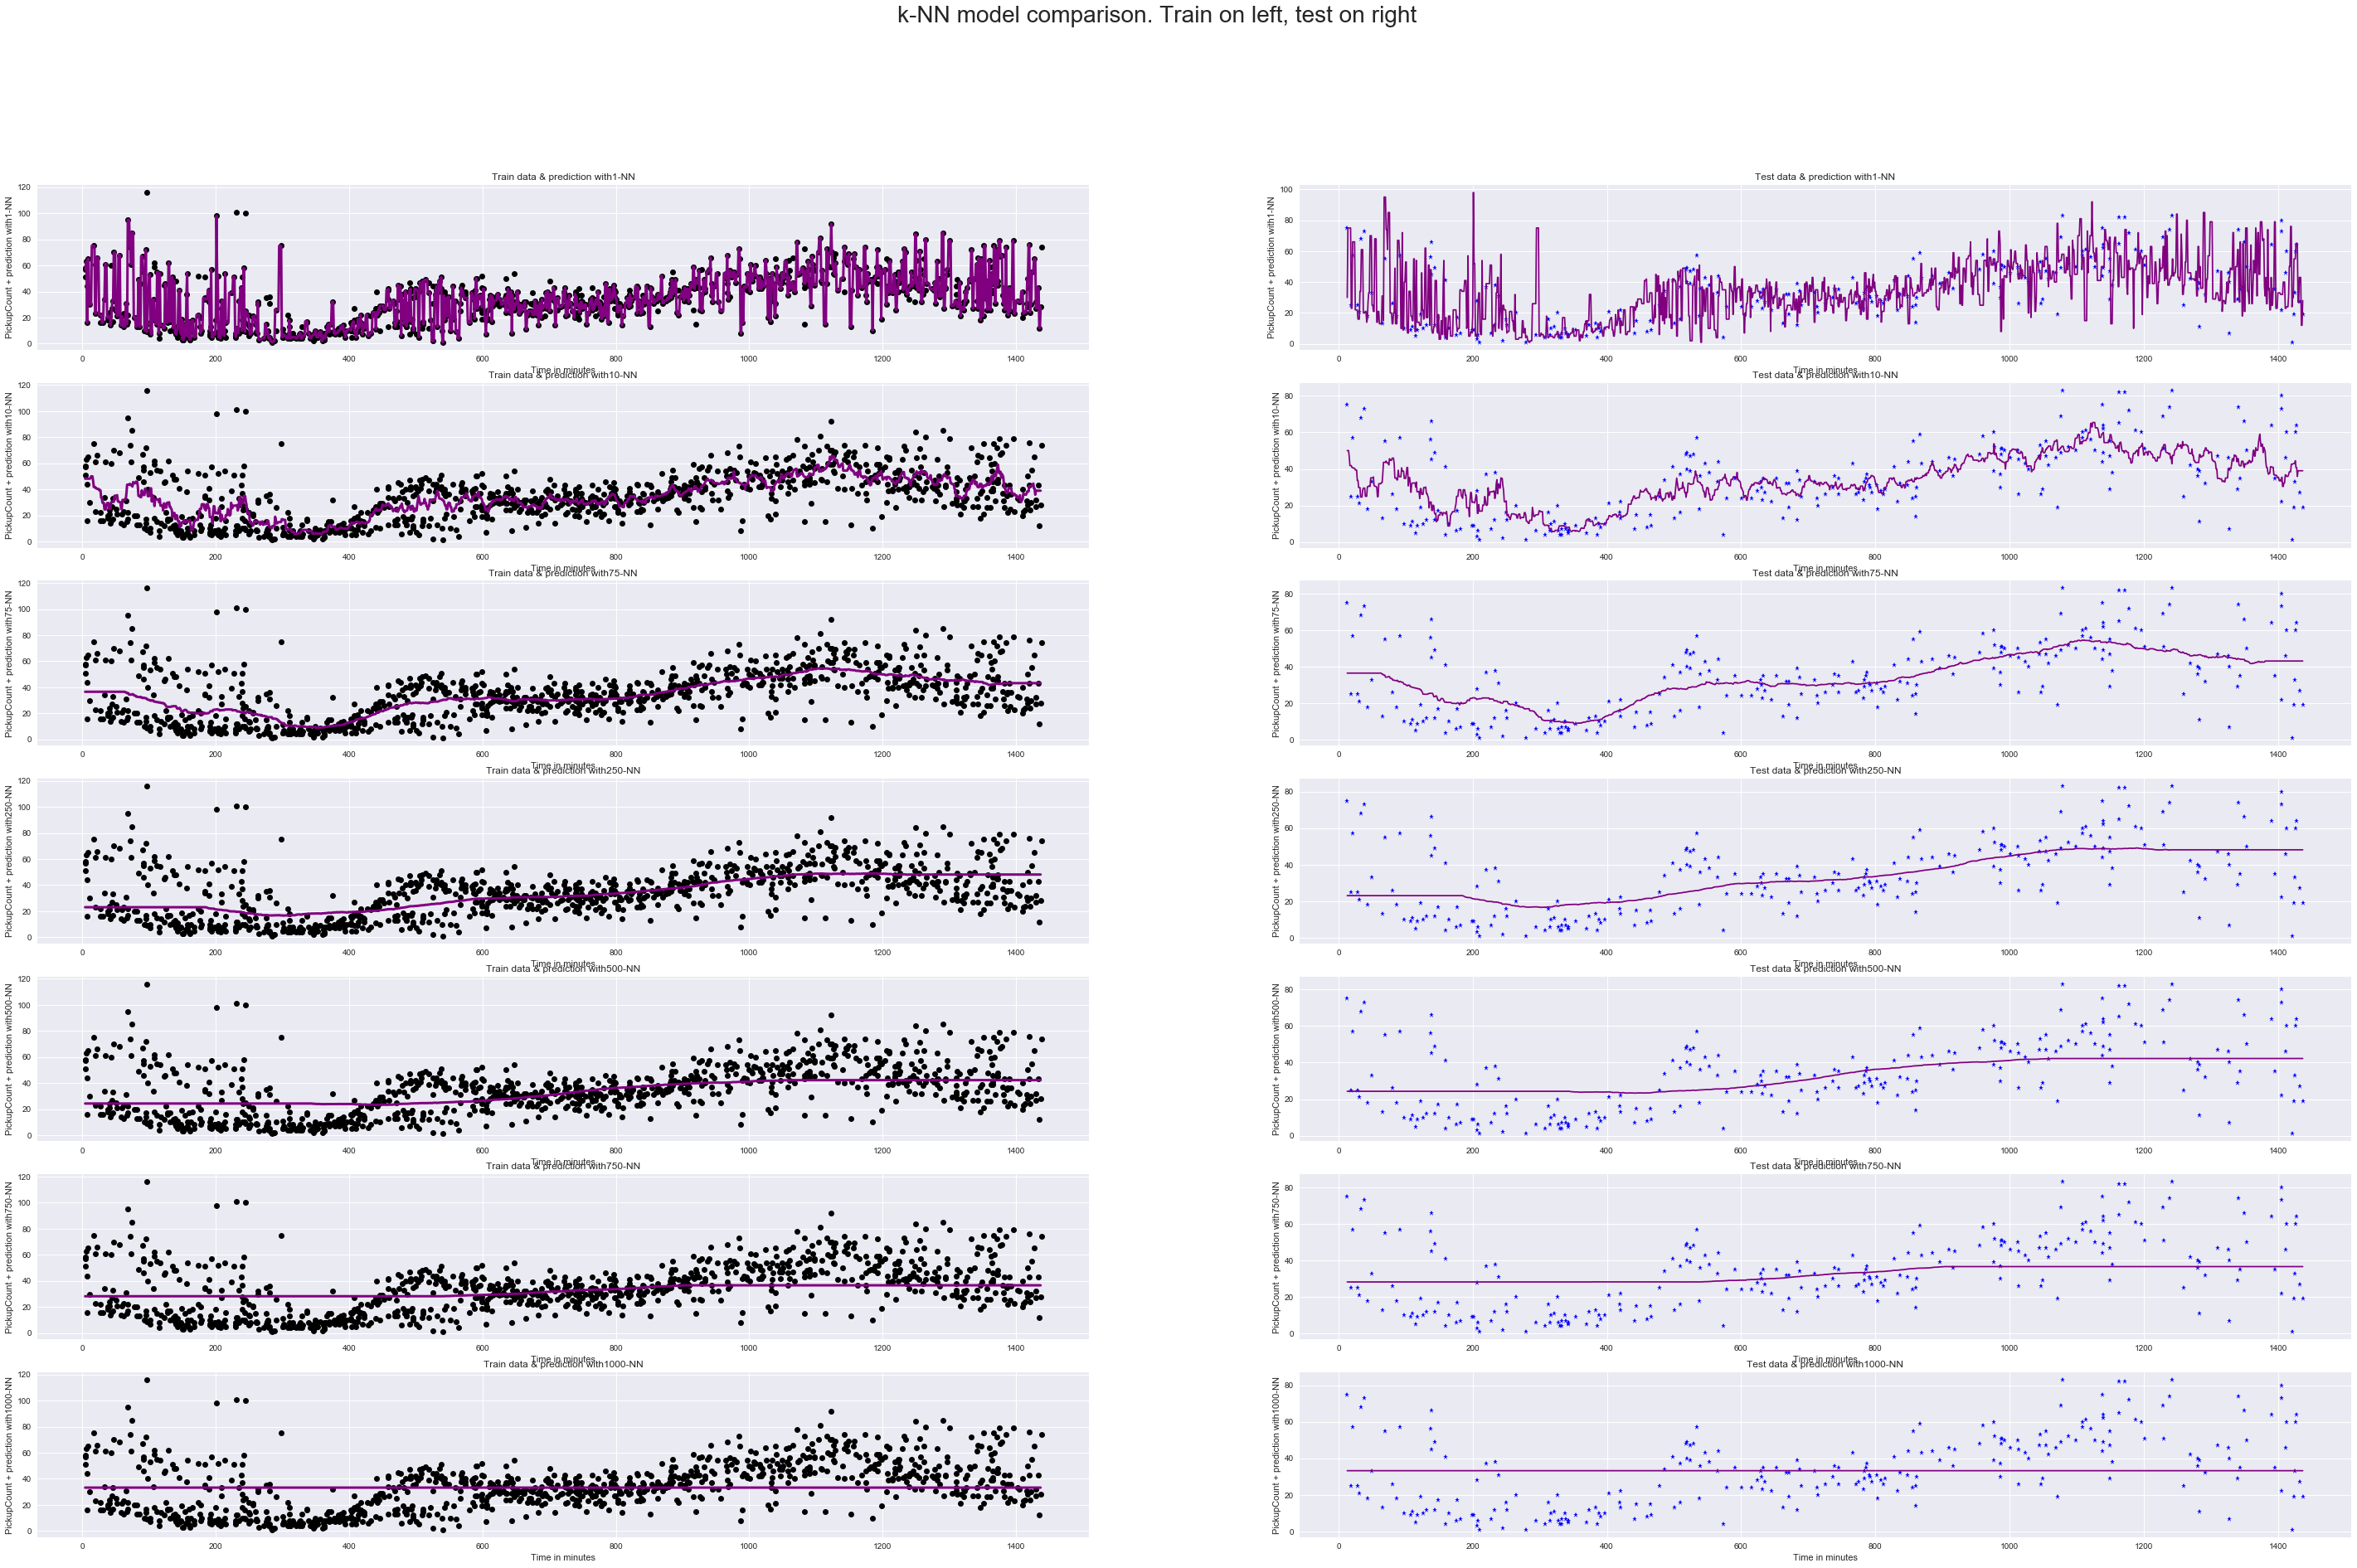

In [12]:
plt.style.use('seaborn')
fig, ax = plt.subplots(7,2, figsize=(50,30))

dummy_train = np.arange(np.min(X_train),np.max(X_train),1).reshape(-1,1)
dummy_test = np.arange(np.min(X_test),np.max(X_test),1).reshape(-1,1)

row = 0

# unpack the dictionary and run through each of the k models
for k, model in KNNModels.items():
    train_predictions = model.predict(dummy_train)
    test_predictions = model.predict(dummy_test)

    # plot train data on the left
    left = 0
    ax[row][left].plot(X_train, y_train, 'o', label="train data", c='black')
    ax[row][left].plot(dummy_train, train_predictions, 
                       label="{}-NN".format(k), c='purple', linewidth=3)

    # plot test data on the right
    right = 1
    ax[row][right].plot(X_test, y_test, '*', label="test data", c="blue")
    ax[row][right].plot(dummy_test, test_predictions, label="{}-NN".format(k), c='purple')

    # label axes for left graphs
    ax[row][left].set_xlabel("Time in minutes")
    y_label = "PickupCount + prediction with" + str(k) +"-NN"
    ax[row][left].set_ylabel(y_label)
    title = "Train data & prediction with" + str(k) +"-NN"
    ax[row][left].set_title(title)

    # label axes for right graphs
    ax[row][right].set_xlabel("Time in minutes")
    ax[row][right].set_ylabel(y_label)
    title = "Test data & prediction with" + str(k) +"-NN"
    ax[row][right].set_title(title)

    row = row + 1


# set main title across all subplots
fig.suptitle('k-NN model comparison. Train on left, test on right', y=0.98, fontsize =28);

**Comments** Note that k=1 results in an overfit model. Only one observation is included to calculate the mean. As k approaches 1000, the prediction becomes the average of all observations y. At first glance, it looks like k=75 or produces the best model, particularly around 6 in the morning (250-300) minutes. 

**2.3 [3 pts]. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**



In [13]:
r2_train = []
r2_test = []

for k, model in KNNModels.items():
    yhat1_train = model.predict(X_train_np)
    yhat1_test = model.predict(X_test_np)
    # Score the model based on trainning data
    r2_train.append(sk.metrics.r2_score(train_data['PickupCount'], yhat1_train))
    # Score the model based on testing data
    r2_test.append(sk.metrics.r2_score(test_data['PickupCount'], yhat1_test))

r2_results = pd.DataFrame({'R-squared train': r2_train, 'R-squared test': r2_test}, index = k_list )    

r2_results


,R-squared train,R-squared test
1,0.667533,-0.074464
10,0.469673,0.414593
75,0.418806,0.479658
250,0.343803,0.394991
500,0.276392,0.302357
750,0.169987,0.179605
1000,0.000000,-0.000032


**Comment:** k=75 seems a reasonable choice as R squared is the highest (~48%) for that value of k. As the R squard is similar for both the train and test set, the model is not overfit. Note that the overfit model of k=1 performs best on the training set, but poorly on the test set, confirming overfit. 

**2.4 [3 pts]. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.



Text(0, 0.5, 'R-squared')

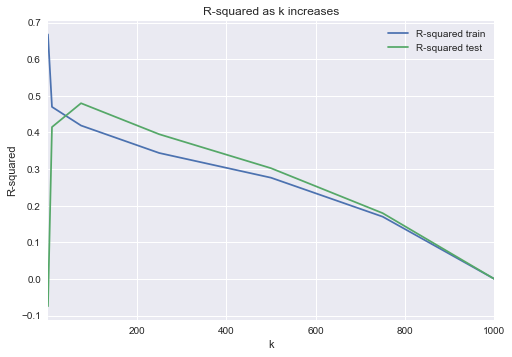

In [14]:
# Plot R-squared
r2_ax = r2_results.plot(title="R-squared as k increases")
r2_ax.set_xlabel("k")
r2_ax.set_ylabel("R-squared")

**2.5 [9 pts]. Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

**Answer**: A regression model that uses k=n will not produce a good model. Possibly R squared will be zero or negative, and perform worse than the mean of the respone data. 

2. What does an $R^2$ score of $0$ mean?  

**Answer**: An $R^2$ of $0$ indicates that the model explains none of the variability of the response data around its mean.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

**Answer**: A negative $R^2$ score indicates that the model perform worse as an estimate than mean of the response data. We observe a slightly negatie $R^2$ on the test data for k=1000

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

**Answer**: The training and test plots show similar trends, except where k=1. For k=1, we observe a typical overfitting pattern: the model performs well on training data, and not well on the test data. As k increase to 10 and 75 we observe both train and test improve significantly. As k increases further, the model deteriorates in a similar fashion on both the train and test data.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

**Answer**: The best value for k is 75. K=75 seems a reasonable choice as R squared is the highest (~48%) for that value of k. As the R squard is similar for both the train  and test set, the model is not overfit.

6. How would the plots compare if mean square error was used as the metric instead of $R^2$?  

**Answer**: If mean square error was used as the metric instead of $R^2$, graphs would inverted. At k=1, the error would be highest for the test set. At k=75, errors would be lowest. Errors would go up as k increases.

## <div class="exercise"> <b> Question 3 [23 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1 [3 pts]**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2 [3 pts]**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4 [2 pts]**. Report the estimates for the slope and intercept for the fitted linear model.

**3.5 [3 pts]**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6 [10 pts]**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers



**3.1 [3 pts]. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.**



In [15]:
# statsmodels approach: add intercepts to the data
OLS_x_train = sm.tools.add_constant(train_data['TimeMin'])
OLS_x_test = sm.tools.add_constant(test_data['TimeMin'])
OLSModel = OLS(train_data['PickupCount'],OLS_x_train).fit()
print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel.summary()

Statmodels results: 
const      17.341910
TimeMin     0.022715
dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     305.9
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           6.06e-60
Time:                        09:26:12   Log-Likelihood:                -4225.3
No. Observations:                1000   AIC:                             8455.
Df Residuals:                     998   BIC:                             8464.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3419      1.050     16.519      0.000      15.282      19.402
TimeMin        0.0227      0.001     17.489      0.000       0.020       0.025
==============================================================================
Omnibus:                      231.966   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              600.753
Skew:                           1.202   Prob(JB):                    3.53e-131
Kurtosis:                       5.939   Cond. No.                     1.62e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**3.2 [3 pts]. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.**

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  



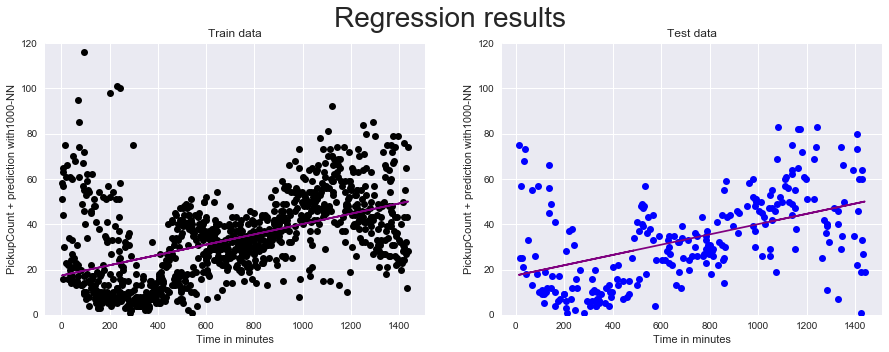

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# run predictions on both the test and train set
train_predictions = OLSModel.predict(OLS_x_train)
test_predictions = OLSModel.predict(OLS_x_test)

# align the vertical axes
ax[0].set_ylim(0,120)
ax[1].set_ylim(0,120)

# create train scatter plot
ax[0].plot(train_data['TimeMin'], train_data['PickupCount'], 'o', label="train data", c='black')
# create prediction line
ax[0].plot(X_train, train_predictions, c='purple')
# label axis and add title
ax[0].set_xlabel("Time in minutes")
ax[0].set_ylabel(y_label)
title = "Train data"
ax[0].set_title(title)

# create test scatter plot
ax[1].plot(test_data['TimeMin'], test_data['PickupCount'], 'o', label="train data", c='blue')
# create prediction line
ax[1].plot(X_test, test_predictions, c='purple')
# label axis and add title
ax[1].set_xlabel("Time in minutes")
ax[1].set_ylabel(y_label)
title = "Test data"
ax[1].set_title(title)

# set main title across all subplots
fig.suptitle('Regression results', y=0.98, fontsize =28);

plt.show()


**3.3 [2 pts]**. Report the $R^2$ score for the fitted model on both the training and test sets.



In [17]:
# run predictions on both the test and train set
train_predictions = OLSModel.predict(OLS_x_train)
test_predictions = OLSModel.predict(OLS_x_test)

# By definition rsquared is the squared correlation coefficient of 
# the dependent variable and the fitted values
# Demonstrating the formula
r2_train = OLSModel.rsquared ## from the model output
print("Train set R squared from the model:", r2_train)
# Manually calculated version
r2_train_man = train_data['PickupCount'].corr(train_predictions)**2 ## calculated manually
print("Train set R squared calculated manually:", r2_train_man, "is identical")

# Calculate R squared for the test set
r2_test_man = test_data['PickupCount'].corr(test_predictions)**2 ## calculated manually
print("Test set R squared from the model:", r2_test_man)

results1 = pd.DataFrame(index = ["train","test"])    
results1['R-squared'] = [r2_train_man,r2_test_man]

results1      


Train set R squared from the model: 0.23457707344420808
Train set R squared calculated manually: 0.23457707344420792 is identical
Test set R squared from the model: 0.2740420607576257


,R-squared
train,0.234577
test,0.274042


**3.4 [2 pts]. Report the estimates for the slope and intercept for the fitted linear model.**



In [18]:
print("The intercept for our model is:", OLSModel.params.const)
print("The slope for our model is:", OLSModel.params.TimeMin)

The intercept for our model is: 17.341909774869514
The slope for our model is: 0.02271549362500802


**3.5 [3 pts]. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 



In [19]:
# printing values from the summary table
print("The 95% confidence interval for the intercept is:", 15.282, "-", 19.402)
print("The 95% confidence interval for the slope is:", 0.020, "-", 0.025)

The 95% confidence interval for the intercept is: 15.282 - 19.402
The 95% confidence interval for the slope is: 0.02 - 0.025


**3.6 [10 pts]. Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

**Answer**: The R squared is lower than the best K, but similar to a k=500. This is expected as the k-500 regression starts resembling a line, similar to this OLS.

2. What does the sign of the slope of the fitted linear model convey about the data?  

**Answer**: The number of rides is positively correlated with the number of minutes. The sign therfore conveys that on average more rides are taken as the day progresses. 

3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 

**Answer**: Zero doesn't fall inside the confidence interval. The CI's therefore indicate there's evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day.

4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  

**Answer**: The $99\%$ confidence intervals for the slope and intercept would be wider thatn the $95\%$ confidence interval, while the midpoint would be identical. The mid-point is the estimated value for slope and intercept. To calculate the $95\%$ CI, we add and substract 1.960 times the standard error. To calculate the 99% CI, we add and substract 2.576 times the standard error.

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

**Answer**: The model doesn't perform reasonably at the end points. I'd recommend caution to use the model around midnight. The hours before midnight, variance is high. The hours after midnight, the model consistently underpredicts. A simple linear model with one independent variable, typically works best around the mean of that variable. It is therefore most appropriate around the mean and gets less appropriate for values further from the mean.
0 is the begining of the day and 1440 is the end of the day and a minute later will be the start of the next day. This suggests that request between 0 and 1440 should not change by much. The model is positively corelated to time hence over predicting for time 1440 and underpredicting at 0

## <div class="exercise"> <b> Question 4 [12 pts] </b></div>

We next consider investigating how the day of the week is associated with pickups to improve both the predictive accuracy of the models and help with more in depth interpretations.  We begin by using the non-parametric *k*-NN approach.   

**4.1 [2 pts]**. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday. 

**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.

**4.3 [3 pts]**. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot). 

**4.4 [4 pts]**. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.






### Answers


**4.1 [2 pts]. Create a binary variable `Weekend` that indicates whether `Day` is either Saturday or Sunday.** 



In [20]:
data = pd.read_csv("./data/nyc_taxi.csv")
# add a weekend variable
data['Weekend'] = np.where(((data['Day'] == 'Sun') | (data['Day'] == 'Sat')), 1, 0)
# look at the data
data.head()

,TimeMin,PickupCount,Day,Weekend
0,860,33,Fri,0
1,17,75,Sun,1
2,486,13,Sun,1
3,300,5,Thu,0
4,385,10,Thu,0


**4.2 [3 pts]**. Build a 'multiple' $k$-NN regression model to predict `PickupCount` as a function of `TimeMin` and `Weekend`.  Use the $k$ you chose as the best from problem 2.5.  Hint/suggestion: if you want to force the nearest neighbors to be within a subgroup (weekend vs. weekday), then you can inflate the binary indicator by mutiplying it by a number larger than the range of `TimeMin`.


In [21]:
# inflating the binary indicator by mutiplying it by a number larger than the range of TimeMin
# to force the nearest neighbors to be within a subgroup (weekend vs. weekday)
data['Weekend_adj'] = data['Weekend'] * 1500

# splitting the datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)

In [22]:
# store the independent variables separately, and drop day as not numeric
X_train = train_data.drop(columns=['PickupCount','Day','Weekend'])
X_test = test_data.drop(columns=['PickupCount','Day','Weekend'])

# limit the target variable to pickup count for both the train and test dataset
y_train = train_data['PickupCount']
y_test = test_data['PickupCount']

In [23]:
# Do the KNN regressions for k=75
k = 75
knnreg = KNeighborsRegressor(n_neighbors=k)
KNNModel = knnreg.fit(X_train, y_train)

# print the model
KNNModel

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=75, p=2,
                    weights='uniform')

In [24]:
r2_train = []
r2_test = []

yhat1_train = KNNModel.predict(X_train)
yhat1_test = KNNModel.predict(X_test)
r2_score_train = sk.metrics.r2_score(train_data['PickupCount'], yhat1_train)
r2_train = r2_score_train
r2_test = sk.metrics.r2_score(test_data['PickupCount'], yhat1_test)


knn42_r2_results = pd.DataFrame(index = ['k=75'])    
knn42_r2_results['R-squared train'] = r2_train
knn42_r2_results['R-squared test'] = r2_test

knn42_r2_results


,R-squared train,R-squared test
k=75,0.646084,0.642972


**4.3 [3 pts]. Plot the predictions of your $k$-NN regression model against `TimeMin` for the 2 types of days on the same plot: weekends and weekdays (overlay these on top of the scatterplot).**


Text(0.5, 1.0, 'k=75 knn regression, weekend (black) vs. weekday (red)')

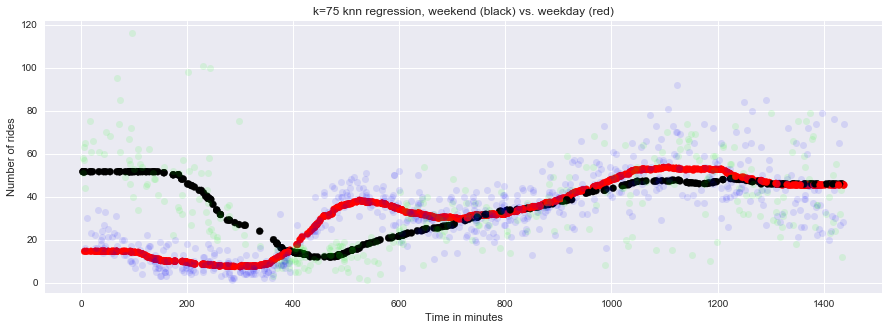

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# calculate predictions
train_predictions = KNNModel.predict(X_train)

color = X_train.copy()
color['color'] = 'black'
color.loc[color.Weekend_adj == 0,'color'] = 'red'

# plot the data with weekend as a color indicator
ax.scatter(X_train['TimeMin'], train_predictions, c=color['color'])
weekend_data = train_data[train_data['Weekend']==1]
week_data = train_data[train_data['Weekend']==0]
ax.plot(weekend_data['TimeMin'], weekend_data['PickupCount'], 'o', label="train data weekend", c='lime', alpha=.1)
ax.plot(week_data['TimeMin'], week_data['PickupCount'], 'o', label="train data week", c='blue', alpha=.1)

# label axes and set titel
ax.set_xlabel("Time in minutes")
ax.set_ylabel("Number of rides")
title = "k=75 knn regression, weekend (black) vs. weekday (red)"
ax.set_title(title)


**4.4 [4 pts]. Describe any differences you observe between weekends and weekdays and why these make sense or are surprising.**


**Answer**: Weekdays and weekends are quite different. Most nightly rides are taken over the weekend, while most morning rides are taken during weekdays. This makes perfect sence as folks party more over the weekend, and commute more to work on weekdays.


##### <div class="exercise"> <b> Question 5 [27 pts] </b></div>

Finally we turn to multiple regression models to see if there is a weekend affect.  Note: Use sklearn to do the modeling unless otherwise stated.


**5.1 [6 pts]**. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.

**5.2 [6 pts]**. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.

**5.3 [3 pts]**. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.

**5.4 [4 pts]**. Determine if the model in 5.3 is a more accurate model than the *k*-NN model in 4.2.  Why do you suppose this is the case?

**5.5 [5 pts]**. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot of the training data). How does this compare to the plot from 4.3?

**5.6 [3 pts]**. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.

### Answers

**5.1 [6 pts]. Fit a multiple regression model using statsmodels to predict `PickupCount` as a function of `TimeMin` and `Weekend` (no interaction term).  Answer the following questions in the context of this model:**

1. Interpret the estimated $\beta$ coefficients associated with the two predictors. 

2. Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.


In [26]:
# prepare the data again as we need to add an intercept
data = pd.read_csv("./data/nyc_taxi.csv")
# add a weekend variable
data['Weekend'] = np.where(((data['Day'] == 'Sun') | (data['Day'] == 'Sat')), 1, 0)

In [27]:
# create training in test data
train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)
# store the independent variables separately, and drop day as not numeric

# add intercept, taking into account both regressors
OLS_x_train = sm.tools.add_constant(train_data[['TimeMin','Weekend']])
OLS_x_test = sm.tools.add_constant(test_data[['TimeMin','Weekend']])

# limit the target variable to pickup count for both the train and test dataset
y_train = train_data['PickupCount']
y_test = test_data['PickupCount']

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
# fit the model on the training data
OLSModel = OLS(y_train,OLS_x_train).fit()
print("Statmodels results: \n",OLSModel.params,sep="")

OLSModel.summary()

Statmodels results: 
const      15.747510
TimeMin     0.022754
Weekend     4.638308
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PickupCount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     164.4
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           1.93e-62
Time:                        09:26:13   Log-Likelihood:                -4216.4
No. Observations:                1000   AIC:                             8439.
Df Residuals:                     997   BIC:                             8454.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7475      1.107     14.220      0.000      13.574      17.921
TimeMin        0.0228      0.001     17.665      0.000       0.020       0.025
Weekend        4.6383      1.098      4.223      0.000       2.483       6.793
==============================================================================
Omnibus:                      183.150   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.494
Skew:                           1.008   Prob(JB):                     1.63e-90
Kurtosis:                       5.421   Cond. No.                     1.99e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**5.1.1** <BR>
Interpret the estimated  𝛽  coefficients associated with the two predictors. <BR>
**Answer:**
The intercept indicates the ride baseline: the ride count, assuming it's a weekday and midnight.
The coefficient for TimeMin indicates the average increase in rides as the hours in the day progress, while controlling for weekend or weekday: ~0.02.
The coefficient for Weekend indicates how many more rides on average we should expect during weekend days, while controlling for the time of day: ~4.6

**5.1.2**<BR> Report the 95% confidence intervals and perform formal hypothesis tests to determine whether the associations are significant.<BR>
**Answer:**
The 95% confidence interval for the intercept is: 13.574 - 17.921
The 95% confidence interval for TimeMin is: 0.020 - 0.025
The 95% confidence interval for Weekend is: 2.483 - 6.793

The standard error for the intercept is 1.107. The t-statistic of 14.220 measures the number of standard deviations this number is away from 0. The p-value indicates the probability we'd find this t-statistic if the intercept was actually 0. This p-value is 0.

The standard error for the TimeMin slope is 0.001. The t-statistic of 17.665 measures the number of standard deviations this number is away from 0. The p-value indicates the probability we'd find this t-statistic if the slope was actually 0. This p-value is 0.

The standard error for the TimeMin Weekend is 1.098. The t-statistic of 4.223 measures the number of standard deviations this number is away from 0. The p-value indicates the probability we'd find this t-statistic if the slope was actually 0. This p-value is 0.



**5.2 [6 pts]. Fit polynomial regression models to predict `PickupCount` as a function of `TimeMin` for polynomials of 2,3,4,5, and 6.  Determine which of these 5 models performs best at predicting `PickupCount` on the test set.**



In [29]:
# prepare the data again as we need to add an intercept
data = pd.read_csv("./data/nyc_taxi.csv")
# add a weekend variable
data['Weekend'] = np.where(((data['Day'] == 'Sun') | (data['Day'] == 'Sat')), 1, 0)

In [30]:
# create training in test data

data['TimeMin_2'] = data['TimeMin']**2
data['TimeMin_3'] = data['TimeMin']**3
data['TimeMin_4'] = data['TimeMin']**4
data['TimeMin_5'] = data['TimeMin']**5
data['TimeMin_6'] = data['TimeMin']**6

train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)
# store the independent variables separately, and drop day as not numeric

# limit the target variable to pickup count for both the train and test dataset
y_train = train_data['PickupCount']
y_test = test_data['PickupCount']

In [31]:
regress_poly = []
#second polynomial
regress_poly.append(LinearRegression(fit_intercept=True).
                    fit(train_data[['TimeMin','TimeMin_2']], 
                        y_train))
#third polynomial
regress_poly.append(LinearRegression(fit_intercept=True).
                    fit(train_data[['TimeMin','TimeMin_2','TimeMin_3']],
                        y_train))
#fourth polynomial
regress_poly.append(LinearRegression(fit_intercept=True).
                    fit(train_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4']], 
                        y_train))
#fifth polynomial
regress_poly.append(LinearRegression(fit_intercept=True).
                    fit(train_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4','TimeMin_5']], 
                        y_train))
#sixth polynomial
regress_poly.append(LinearRegression(fit_intercept=True).
                    fit(train_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4','TimeMin_5', 'TimeMin_6']],
                        y_train))

# print coefficients
polynomial = 2
for regression in regress_poly:
    print("Polynomial", polynomial, " Beta0 =", regression.intercept_ ,",\n Beta1 =", regression.coef_)
    polynomial = polynomial + 1

Polynomial 2  Beta0 = 22.585697972277643 ,
 Beta1 = [1.45841447e-03 1.47646508e-05]
Polynomial 3  Beta0 = 41.55254802691911 ,
 Beta1 = [-1.50475644e-01  2.77764848e-04 -1.21945891e-07]
Polynomial 4  Beta0 = 44.159205925385194 ,
 Beta1 = [-1.84256296e-01  3.81408768e-04 -2.33503004e-07  3.87802895e-11]
Polynomial 5  Beta0 = 50.05298393128301 ,
 Beta1 = [-2.97615619e-01  9.21660435e-04 -1.22904749e-06  8.16543484e-10
 -2.16451480e-13]
Polynomial 6  Beta0 = 35.14215901240307 ,
 Beta1 = [-4.34152497e-06 -7.56590923e-04  2.82921900e-06 -3.96391528e-09
  2.49114677e-12 -5.90443544e-16]


In [32]:
yhat_test = []
r2_test_poly = []
mse_test_poly = []

## run model and calculate r squared and mean squared errors
# 2nd polynomial
yhat_test_poly2 = regress_poly[0].predict(
    test_data[['TimeMin','TimeMin_2']])
r2_test_poly.append(sk.metrics.r2_score(test_data['PickupCount'], yhat_test_poly2))
mse_test_poly.append(sk.metrics.mean_squared_error(test_data['PickupCount'], yhat_test_poly2))

# 3rd polynomial
yhat_test_poly3 = regress_poly[1].predict(
    test_data[['TimeMin','TimeMin_2','TimeMin_3']])
r2_test_poly.append(sk.metrics.r2_score(test_data['PickupCount'], yhat_test_poly3))
mse_test_poly.append(sk.metrics.mean_squared_error(test_data['PickupCount'], yhat_test_poly3))

# 4th polynomial
yhat_test_poly4 = regress_poly[2].predict(
    test_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4']])
r2_test_poly.append(sk.metrics.r2_score(test_data['PickupCount'], yhat_test_poly4))
mse_test_poly.append(sk.metrics.mean_squared_error(test_data['PickupCount'], yhat_test_poly4))

# 5th polynomial
yhat_test_poly5 = regress_poly[3].predict(
    test_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4','TimeMin_5']])
r2_test_poly.append(sk.metrics.r2_score(test_data['PickupCount'], yhat_test_poly5))
mse_test_poly.append(sk.metrics.mean_squared_error(test_data['PickupCount'], yhat_test_poly5))

# 6th polynomial
yhat_test_poly6 = regress_poly[4].predict(
    test_data[['TimeMin','TimeMin_2','TimeMin_3','TimeMin_4','TimeMin_5','TimeMin_6']])
r2_test_poly.append(sk.metrics.r2_score(test_data['PickupCount'], yhat_test_poly6))
mse_test_poly.append(sk.metrics.mean_squared_error(test_data['PickupCount'], yhat_test_poly6))

results_poly = pd.DataFrame(index = ["Poly2","Poly3", "Poly4", "Poly5", "Poly6"])    
results_poly['R-squared'] = r2_test_poly
results_poly['MSE'] = mse_test_poly

results_poly

,R-squared,MSE
Poly2,0.279742,286.847326
Poly3,0.420417,230.822530
Poly4,0.423748,229.495926
Poly5,0.440260,222.919854
Poly6,0.409391,235.213699


**Comment** <BR> The 5th polynomial has the hightest R squared on the test set, and the lowest mean squared error. The sixt polynomial has a lower R squared, and is therfore probably overfit.

**5.3 [3 pts]. Create a multiple regression model with `Weekend`, the best polynomial order of `TimeMin` from the previous part, and the interactions between `Weekend` and all the polynomial terms for `TimeMin`.**


In [33]:
# prepare the data again as we need to add an intercept
data = pd.read_csv("./data/nyc_taxi.csv")
# add a weekend variable
data['Weekend'] = np.where(((data['Day'] == 'Sun') | (data['Day'] == 'Sat')), 1, 0)

# create polynomial factors
data['TimeMin_2'] = data['TimeMin']**2
data['TimeMin_3'] = data['TimeMin']**3
data['TimeMin_4'] = data['TimeMin']**4
data['TimeMin_5'] = data['TimeMin']**5

# create interaction variables
data['TimeMin_2_we'] = data['TimeMin_2'] * data['Weekend']
data['TimeMin_3_we'] = data['TimeMin_3'] * data['Weekend']
data['TimeMin_4_we'] = data['TimeMin_4'] * data['Weekend']
data['TimeMin_5_we'] = data['TimeMin_5'] * data['Weekend']

train_data, test_data = train_test_split(data, test_size=0.2, random_state=109)
# store the independent variables separately, and drop day as not numeric

# limit the target variable to pickup count for both the train and test dataset
y_train = train_data['PickupCount']
y_test = test_data['PickupCount']

In [34]:
# drop the target column and the non-numeric day column
X_train = train_data.drop(columns=['PickupCount', 'Day'])
X_test = test_data.drop(columns=['PickupCount', 'Day'])

In [35]:
# fit the model
regress_poly5_we_interact = (LinearRegression(fit_intercept=True).
                    fit(X_train, y_train))

## run model and calculate r squared and mean squared errors
yhat_poly5_we_interact = regress_poly5_we_interact.predict(X_test)
r2_test_poly5_we_interact = sk.metrics.r2_score(y_test, yhat_poly5_we_interact)
mse_test_poly5_we_interact = sk.metrics.mean_squared_error(y_test, yhat_poly5_we_interact)
print("Test R squared for the 5th polynomial model with weekend interaction variables: ", r2_test_poly5_we_interact)
print("Test MSE for the same model:", mse_test_poly5_we_interact)

Test R squared for the 5th polynomial model with weekend interaction variables:  0.4501981850492486
Test MSE for the same model: 218.96209153575248



**5.4 [4 pts]. Determine if the model in 5.3 is a more predictive model than the *k*-NN model in 4.2.  Why do you suppose this is the case?**

knn42_r2_results

In [36]:
print("Comparing to the knn results from 4.2")
knn42_r2_results

Comparing to the knn results from 4.2


,R-squared train,R-squared test
k=75,0.646084,0.642972


At 45%, the model in 5.3 has a lower R squared on the test set than the 75-NN model from 4.2. It seems reasonable to assume the relationship between time and rides is not polynomious. It is therefore not surprising a non-parametric model such as k-nn is more predictive.

**5.5 [5 pts]. Plot the predictions of your interaction model from 5.4 against `TimeMin` for the 2 types of days: weekends and weekdays (overlay this on top of the scatterplot). How does this compare to the plot from 4.3?**



Text(0.5, 1.0, 'Ordinairy Least Squares, weekend (black) vs. weekday (red)')

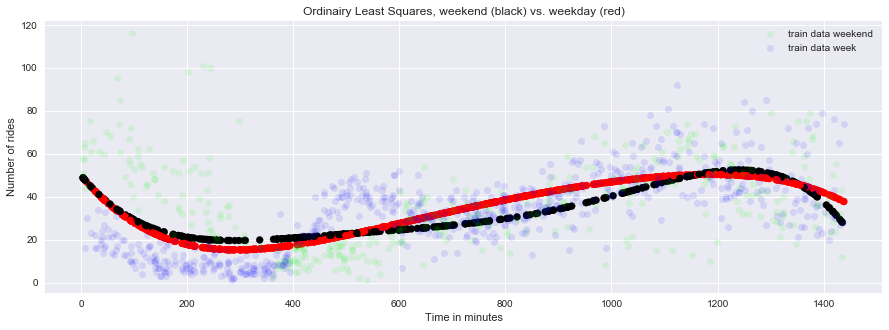

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# calculate predictions
train_predictions = regress_poly5_we_interact.predict(X_train)

color = X_train.copy()
color['color'] = 'black'
color.loc[color.Weekend == 0,'color'] = 'red'

ax.scatter(X_train['TimeMin'], train_predictions, c=color['color'] )
weekend_data = train_data[train_data['Weekend']==1]
week_data = train_data[train_data['Weekend']==0]
ax.plot(weekend_data['TimeMin'], weekend_data['PickupCount'], 'o', label="train data weekend", c='lime', alpha=.1)
ax.plot(week_data['TimeMin'], week_data['PickupCount'], 'o', label="train data week", c='blue', alpha=.1)

# plot the data with weekend as a color indicator
ax.legend()

# label axes and set titel
ax.set_xlabel("Time in minutes")
ax.set_ylabel("Number of rides")
title = "Ordinairy Least Squares, weekend (black) vs. weekday (red)"
ax.set_title(title)

The graph illustrates why OLS is less predictive than knn. OLS doesn't capture the stark differences around midnight and 9am as well as the knn. The OLS curves look pretty similar between weekday and weekend, while the knn curves look more distint between weekday and weekend day.

**5.6 [3 pts]. Suggest an additional feature that could improve the predictive ability of the models considered so far (either included or not in the provided data set) and explain why this should help.  Note: this is very open ended and there is not a single correct answer.**

**Answer**: There are probably quite a few features that could improve this model. Some features I would add are "precipitation level", "temperature", "holiday" and "number of flights in the next 3 hours". I would assume folks take more rides as precipitation, temperature and rides got up. I'm also hypothesizing patterns on holidays look more similar weekend patterns.